In [1]:
import pandas as pd
import pandasql as psql
from pandasql import sqldf
import numpy as np
import calendar
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns

sns.set_style("darkgrid")

import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
months_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
short_months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']

days_list = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"] 
regions_list =["North","North East","Southeast","Central-West"]

In [3]:
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
english = pd.read_csv('product_category_name_translation.csv')
state_locations = pd.read_csv('olist_state_locations.csv')
state_names = pd.read_csv('olist_state_names.csv')
date_year = pd.read_csv('olist_date_year.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None


In [4]:
date_year = pd.read_csv('olist_date_year.csv')
date_year['Date'] = pd.to_datetime(date_year['Date'], format= '%Y-%m-%d')

#Change the data types on the time stamp columns
orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']]= orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)


In [5]:
#Create date columns from time stamp columns
orders['order_date'] = orders['order_purchase_timestamp'].apply(pd.to_datetime).dt.date
orders['order_date'] = orders['order_date'].apply(pd.to_datetime)
orders['carrier_date'] = orders['order_delivered_carrier_date'].apply(pd.to_datetime).dt.date
orders['carrier_date'] = orders['carrier_date'].apply(pd.to_datetime)
orders['customer_date'] = orders['order_delivered_customer_date'].apply(pd.to_datetime).dt.date
orders['customer_date'] = orders['customer_date'].apply(pd.to_datetime)
orders['estiimated_date'] = orders['order_estimated_delivery_date'].apply(pd.to_datetime).dt.date
orders['estiimated_date'] = orders['estiimated_date'].apply(pd.to_datetime)

#Create a  column to count overdue orders
orders['overdue_order'] = np.where( ( (orders['order_delivered_carrier_date'] > orders['order_estimated_delivery_date']) 
                                    | (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']) ), 1 ,0)
#Create columns of days order is overdue
def get_overdue_days(row):
    #print("in get_overdue_days")
    #print(str(row['order_delivered_carrier_date']) + " " + str(row['order_delivered_customer_date']) + " " + str(row['order_estimated_delivery_date']) )    
    
    if row['order_delivered_carrier_date'] > row['order_estimated_delivery_date']:
       date_diff = row['order_delivered_carrier_date'] - row['order_estimated_delivery_date']
       return date_diff.days
    elif row['order_delivered_customer_date'] > row['order_estimated_delivery_date']:
            date_diff = row['order_delivered_customer_date'] - row['order_estimated_delivery_date']
            return date_diff.days
    else: return 0

orders['days_overdue'] =  orders.apply(get_overdue_days , axis=1)

#Create column of delivery time in days.
def get_delivery_days(row):
    #Set date to median
    if pd.isna(row['order_delivered_carrier_date']) | pd.isna(row['order_delivered_customer_date']):
        date_diff = 10
    elif (row['order_delivered_carrier_date'] > row['order_delivered_customer_date']) | pd.isna(row['order_delivered_customer_date']) :
        date_diff = (row['carrier_date'] - row['order_date']).days
    else: 
        date_diff = (row['customer_date'] - row['order_date']).days
    
    return date_diff

orders['delivery_days'] =  orders.apply(get_delivery_days , axis=1)


In [6]:
#remove unneeded columns from data frame 
del orders['order_delivered_carrier_date']
del orders['order_delivered_customer_date']
del orders['order_estimated_delivery_date']
del orders['order_purchase_timestamp']
del orders['order_approved_at']
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         99441 non-null  object        
 1   customer_id      99441 non-null  object        
 2   order_status     99441 non-null  object        
 3   order_date       99441 non-null  datetime64[ns]
 4   carrier_date     97658 non-null  datetime64[ns]
 5   customer_date    96476 non-null  datetime64[ns]
 6   estiimated_date  99441 non-null  datetime64[ns]
 7   overdue_order    99441 non-null  int32         
 8   days_overdue     99441 non-null  int64         
 9   delivery_days    99441 non-null  int64         
dtypes: datetime64[ns](4), int32(1), int64(2), object(3)
memory usage: 7.2+ MB
None


In [7]:
#Query to get the sales, customer info, and product details, dates ect.
sales_query = """ select
                  d.dateyear as year,
                  d.fdom,
                  b.order_id,
                  e.product_category_name_english,
                  b.product_id,
                  c.customer_unique_id,
                  c.customer_zip_code_prefix,
                  c.customer_state,
                  c.customer_city,
                  s.state_name,
                  s.region,
                  a.order_date,
                  d.month,
                  d.dow_name,
                  d.month_name,
                  d.month_short_name,
                  l.Latitude as latitude,
                  l.Longatitude as longatitude,
                  a.overdue_order,
                  a.days_overdue,
                  a.delivery_days,
                  b.price as sales,
                  count(distinct a.order_id) as order_count,
                  count(distinct b.order_id) as item_qty
            from orders a         
            left join items b on a.order_id = b.order_id  
            inner join customers c on a.customer_id = c.customer_id
            left join products p on b.product_id=p.product_id
            left join english e on p.product_category_name=e.product_category_name
            left join date_year d on a.order_date = d.date
            left join state_names s on c.customer_state = s.state_code
            left join state_locations l on c.customer_state = l.geolocation_state
            where a.order_status in("delivered","invoiced","shipped") and dateyear in(2017,2018)
            group by 1,2,3
            having item_qty >0"""

sales_data = psql.sqldf(sales_query)
sales_data['order_date'] = sales_data['order_date'].apply(pd.to_datetime)

print(sales_data.info())
#print(sales_data.head(10))
#sales_data.to_csv('sales_data_summary.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97605 entries, 0 to 97604
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   year                           97605 non-null  int64         
 1   fdom                           97605 non-null  object        
 2   order_id                       97605 non-null  object        
 3   product_category_name_english  96194 non-null  object        
 4   product_id                     97605 non-null  object        
 5   customer_unique_id             97605 non-null  object        
 6   customer_zip_code_prefix       97605 non-null  int64         
 7   customer_state                 97605 non-null  object        
 8   customer_city                  97605 non-null  object        
 9   state_name                     97605 non-null  object        
 10  region                         97605 non-null  object        
 11  order_date     

In [8]:
#print(sales_data.iloc[:,[0,1,2,6,7,9,10]].head())

In [9]:
print(sales_data.iloc[:,18:23].describe())

       overdue_order  days_overdue  delivery_days         sales  order_count
count   97605.000000  97605.000000   97605.000000  97605.000000      97605.0
mean        0.080221      0.683182      12.441463    125.407802          1.0
std         0.271637      4.527573       9.473745    190.139769          0.0
min         0.000000      0.000000       0.000000      0.850000          1.0
25%         0.000000      0.000000       7.000000     41.500000          1.0
50%         0.000000      0.000000      10.000000     79.000000          1.0
75%         0.000000      0.000000      15.000000    139.900000          1.0
max         1.000000    188.000000     210.000000   6735.000000          1.0


In [10]:
order_summary = sales_data.groupby(['year','fdom','month_name']).agg({'order_id': 'nunique', 'sales' : 'sum'}).reset_index()
#Rename the columns
order_summary.columns = ['year','fdom','month_name','Order_Count', 'Sales']
# convert the 'Date' column to datetime data type
order_summary['fdom'] = pd.to_datetime(order_summary['fdom'], format= '%Y-%m-%d')
order_summary['month'] = order_summary['fdom'].dt.month
order_summary['Sales'] =  round(order_summary['Sales'],0)
print(order_summary.info())
print(order_summary.head(24))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   year         21 non-null     int64         
 1   fdom         21 non-null     datetime64[ns]
 2   month_name   21 non-null     object        
 3   Order_Count  21 non-null     int64         
 4   Sales        21 non-null     float64       
 5   month        21 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.1+ KB
None
    year       fdom month_name  Order_Count     Sales  month
0   2017 2017-01-01    January          778  105438.0      1
1   2017 2017-02-01   February         1685  222114.0      2
2   2017 2017-03-01      March         2594  336920.0      3
3   2017 2017-04-01      April         2366  325586.0      4
4   2017 2017-05-01        May         3617  458667.0      5
5   2017 2017-06-01       June         3193  400541.0 

In [11]:
#Delete the last row since there is only 1 order
order_summary = order_summary.iloc[:20]
print(order_summary.head(24))
#order_summary.to_csv('order_summary.csv')

    year       fdom month_name  Order_Count     Sales  month
0   2017 2017-01-01    January          778  105438.0      1
1   2017 2017-02-01   February         1685  222114.0      2
2   2017 2017-03-01      March         2594  336920.0      3
3   2017 2017-04-01      April         2366  325586.0      4
4   2017 2017-05-01        May         3617  458667.0      5
5   2017 2017-06-01       June         3193  400541.0      6
6   2017 2017-07-01       July         3935  447253.0      7
7   2017 2017-08-01     August         4254  515375.0      8
8   2017 2017-09-01  September         4205  553034.0      9
9   2017 2017-10-01    October         4527  593929.0     10
10  2017 2017-11-01   November         7396  897820.0     11
11  2017 2017-12-01   December         5583  681262.0     12
12  2018 2018-01-01    January         7158  859382.0      1
13  2018 2018-02-01   February         6618  763775.0      2
14  2018 2018-03-01      March         7159  898869.0      3
15  2018 2018-04-01     

In [12]:
comp_year = order_summary.drop(order_summary[order_summary.month >8].index).groupby(['year']).agg({'Order_Count': 'sum', 'Sales' : 'sum'}).reset_index()
#Rename the columns
comp_year.columns = ['year','order_count', 'sales']
comp_year['sales'] =  round(comp_year['sales'],0)
comp_year['yoy_orders'] = comp_year['order_count'].diff().fillna(0)
comp_year['yoy_sales'] = comp_year['sales'].diff().fillna(0)
comp_year['yoy_orders_pct'] = round(comp_year['order_count'].pct_change()*100,2).fillna(0)
comp_year['yoy_sales_pct'] = round(comp_year['sales'].pct_change() * 100,2).fillna(0)

print(comp_year.info())
print(comp_year.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            2 non-null      int64  
 1   order_count     2 non-null      int64  
 2   sales           2 non-null      float64
 3   yoy_orders      2 non-null      float64
 4   yoy_sales       2 non-null      float64
 5   yoy_orders_pct  2 non-null      float64
 6   yoy_sales_pct   2 non-null      float64
dtypes: float64(5), int64(2)
memory usage: 240.0 bytes
None
   year  order_count      sales  yoy_orders  yoy_sales  yoy_orders_pct  \
0  2017        22422  2811894.0         0.0        0.0            0.00   
1  2018        53471  6702343.0     31049.0  3890449.0          138.48   

   yoy_sales_pct  
0           0.00  
1         138.36  


In [13]:
comp_year_m = pd.melt(comp_year, 'year', var_name='value_name', value_name='value')

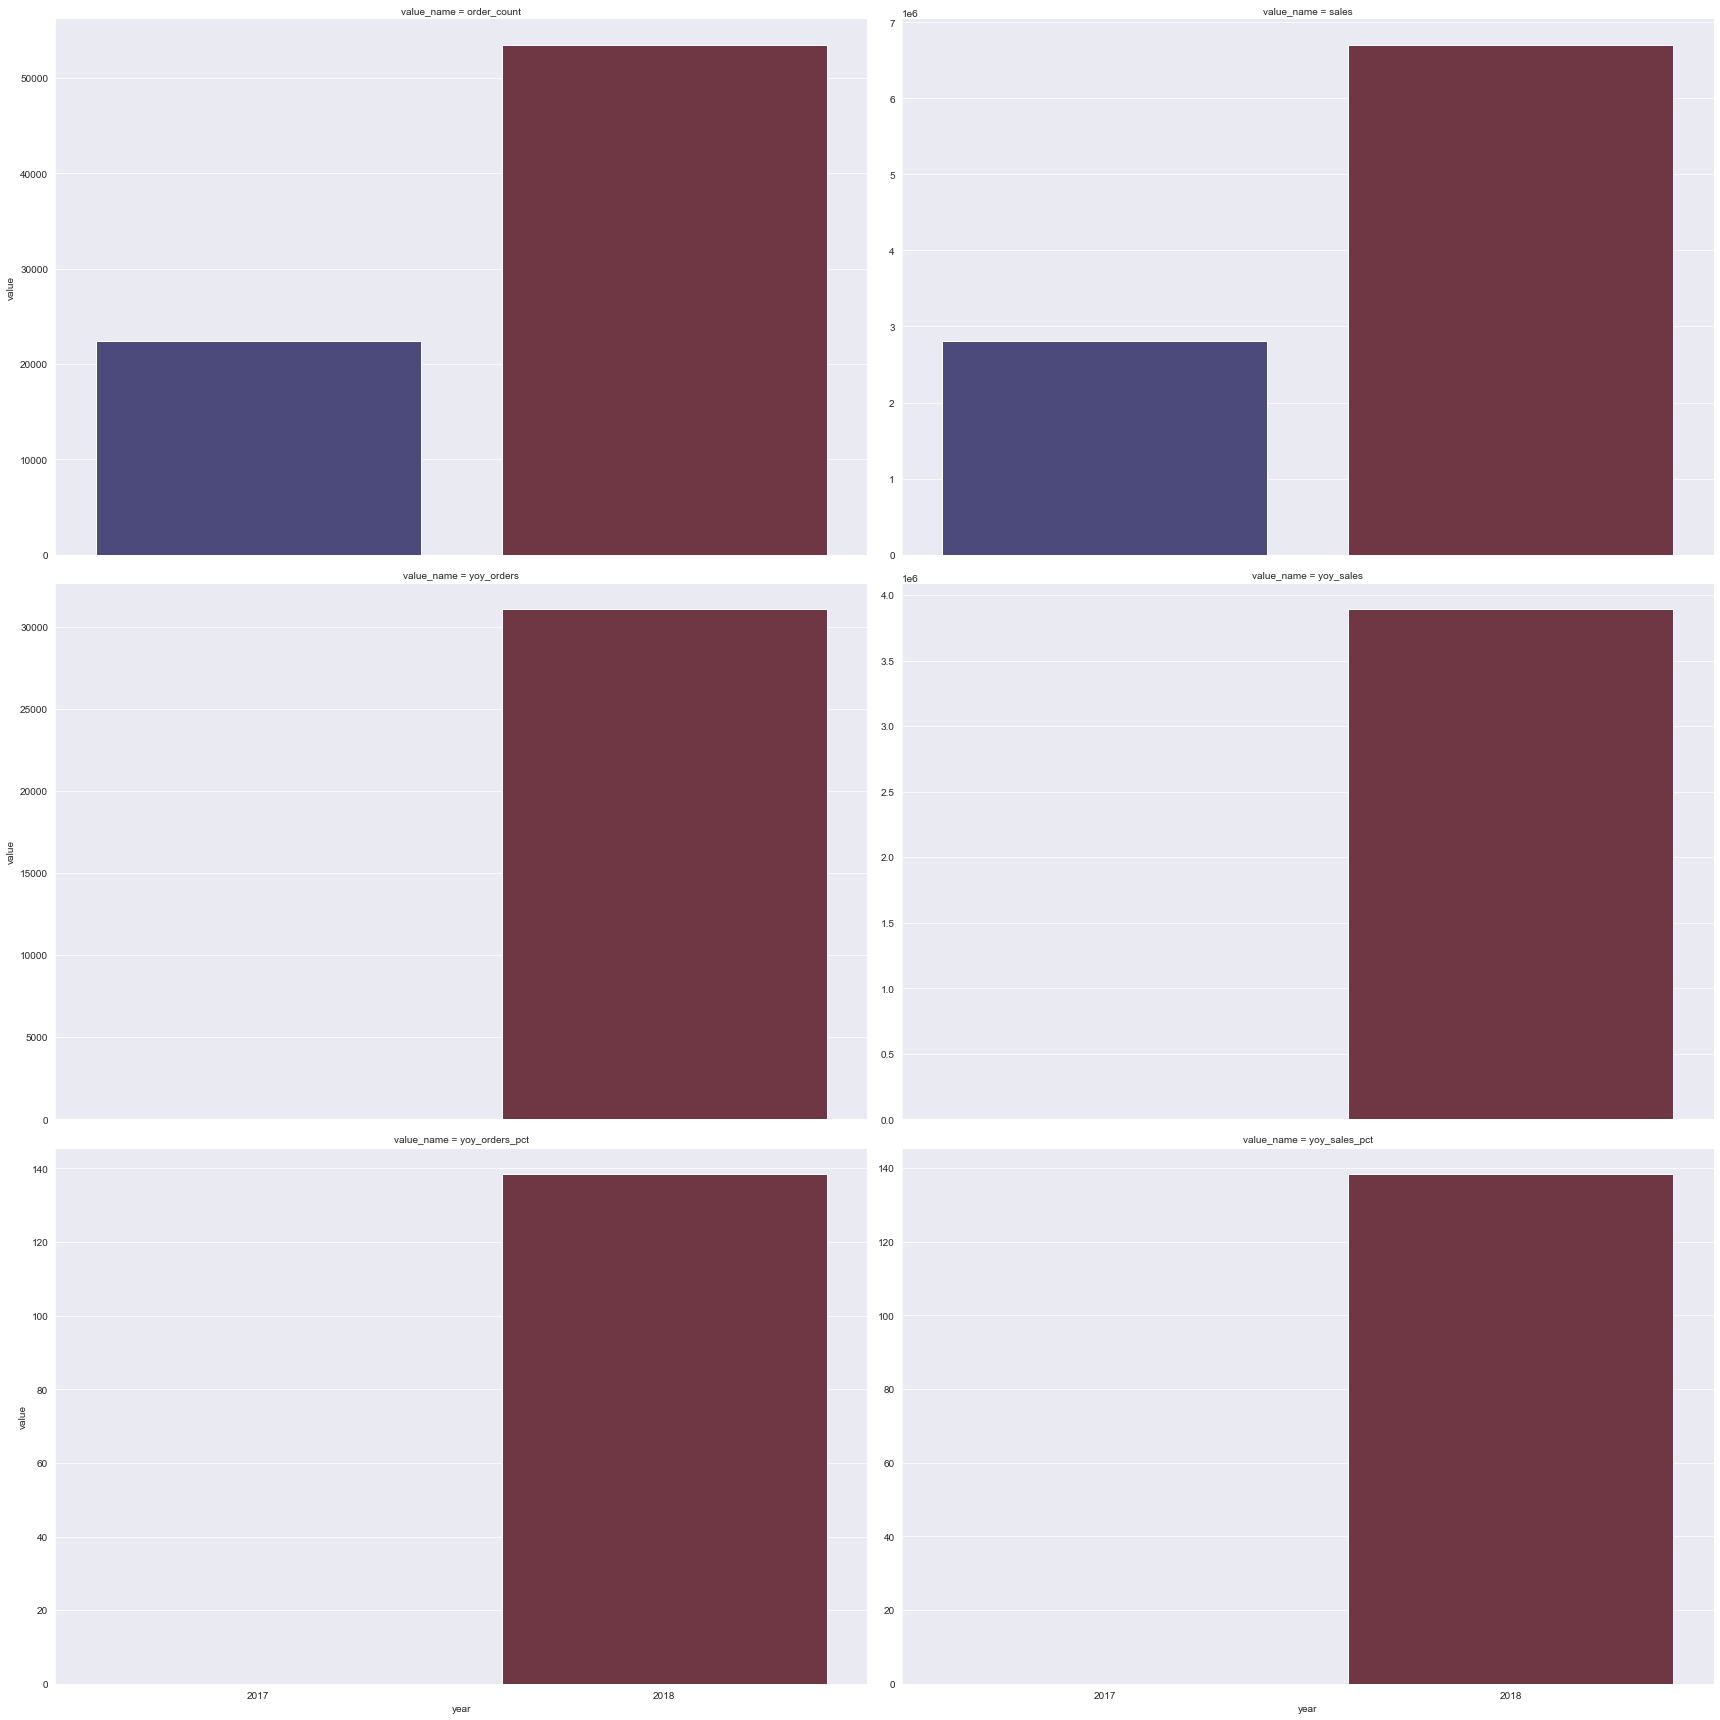

In [14]:
sns.set_style("darkgrid")
chart= sns.catplot(data=comp_year_m, kind='bar',x='year', y='value', col='value_name' 
            ,palette='icefire',height=8, aspect=1.5, col_wrap=2,sharey=False)
#chart.set_titles( fontsize=14,color='darkblue') 
plt.show()

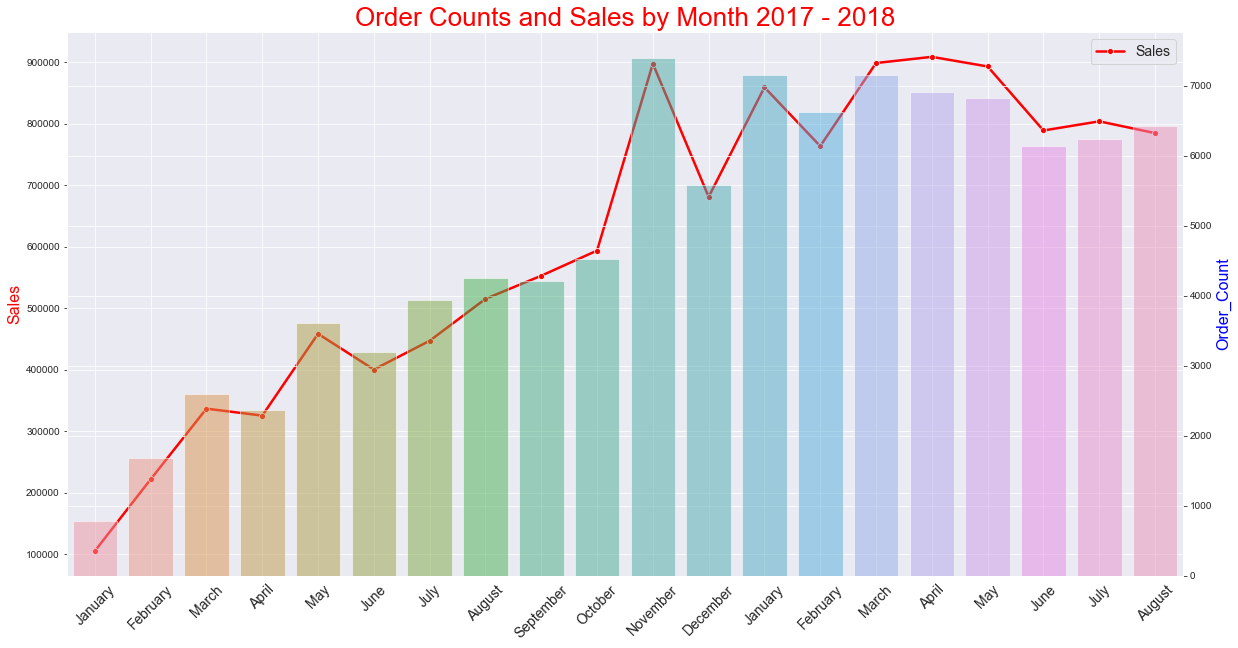

In [15]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Order Counts and Sales by Month 2017 - 2018', fontsize=26, color="red")

sns.lineplot(data = order_summary['Sales'], marker='o', sort = False, ax=ax1, color='red',linewidth = 2.5)
ax1.set_ylabel('Sales', fontsize=16, color='red')
ax1.set_xticks(order_summary['fdom'])
ax1.set_xticklabels(order_summary['month_name'],rotation=45,fontsize=14)
ax1.legend(labels=["Sales"], fontsize=14)

ax2 = ax1.twinx()
ax2.set_ylabel('Sales', fontsize=16, color='blue')
sns.barplot(data = order_summary, x='fdom', y='Order_Count', alpha=0.5, ax=ax2)
ax2.set_xticklabels(order_summary['month_name'],rotation=45)

plt.show()

In [16]:
order_summary['mom_orders'] = order_summary['Order_Count'].diff(1)
order_summary['mom_orders_pct'] = round(order_summary['Order_Count'].pct_change() * 100,2)
order_summary['mom_sales'] = order_summary['Sales'].diff(1)
order_summary['mom_sales_pct'] = round(order_summary['Sales'].pct_change() *100,2)
order_summary['yoy_orders'] = order_summary['Order_Count'].diff(12)
order_summary['yoy_orders_pct'] = round(order_summary['Order_Count'].pct_change(12)*100,2)
order_summary['yoy_sales'] = order_summary['Sales'].diff(12)
order_summary['yoy_sales_pct'] = round(order_summary['Sales'].pct_change(12) * 100,2)
order_summary['month']= order_summary['fdom'].dt.month
#print(order_summary.info())
#print()
print(order_summary.iloc[:,6:10].describe())
print()
print(order_summary.iloc[13:21:,10:14].describe())
#order_summary.to_csv('order_summary.csv')

        mom_orders  mom_orders_pct      mom_sales  mom_sales_pct
count    19.000000       19.000000      19.000000      19.000000
mean    297.000000       15.696842   35762.842105      14.515263
std     991.299372       34.284291  116369.498109      31.360312
min   -1813.000000      -24.510000 -216558.000000     -24.120000
25%    -238.000000       -5.500000  -17401.500000      -2.870000
50%     189.000000        3.030000   37659.000000       7.310000
75%     824.500000       25.725000  115741.000000      21.920000
max    2869.000000      116.580000  303891.000000     110.660000

        yoy_orders  yoy_orders_pct      yoy_sales  yoy_sales_pct
count     7.000000        7.000000       7.000000       7.000000
mean   3524.142857      135.907143  448072.142857     130.527143
std    1146.310084       88.232678  118278.243589      67.853453
min    2167.000000       50.940000  269557.000000      52.300000
25%    2624.500000       73.560000  372713.000000      87.265000
50%    3210.000000      

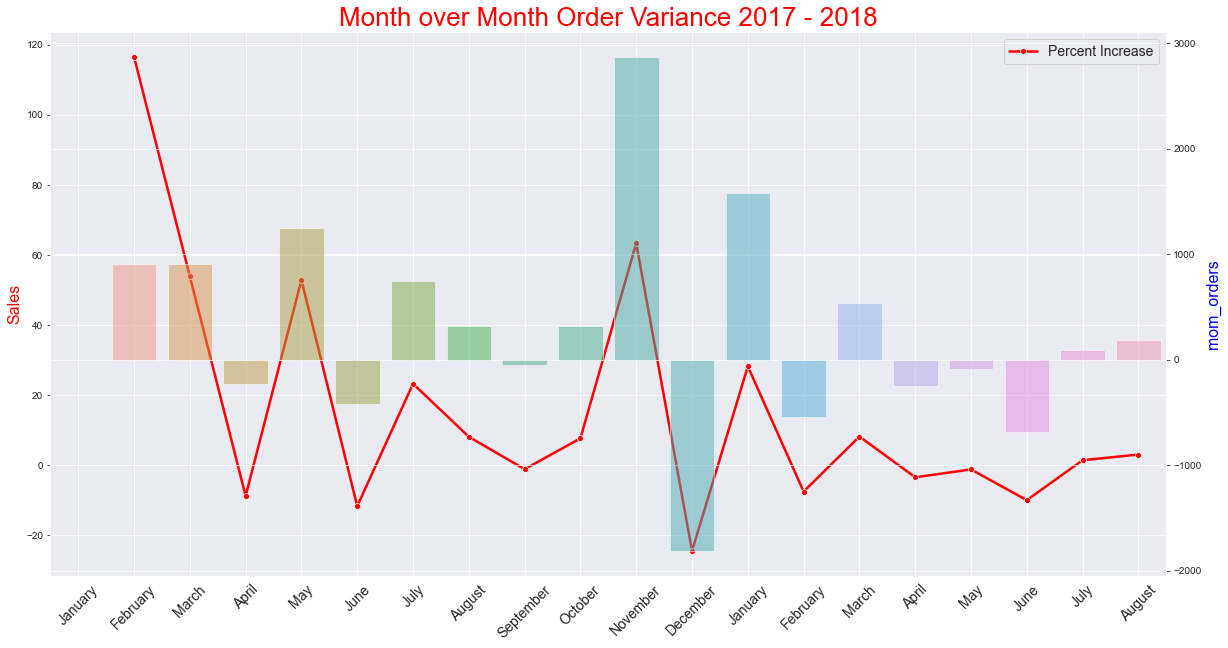

In [17]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Month over Month Order Variance 2017 - 2018', fontsize=26, color="red")

sns.lineplot(data = order_summary['mom_orders_pct'], marker='o', sort = False, ax=ax1, color='red',linewidth = 2.5)
ax1.set_ylabel('Sales', fontsize=16, color='red')
ax1.set_xticks(order_summary['fdom'])
ax1.set_xticklabels(order_summary['month_name'],rotation=45,fontsize=14)
ax1.legend(labels=["Percent Increase"], fontsize=14)

ax2 = ax1.twinx()
ax2.set_ylabel('mom_orders', fontsize=16, color='blue')
sns.barplot(data = order_summary, x='fdom', y='mom_orders', alpha=0.5, ax=ax2)
ax2.set_xticklabels(order_summary['month_name'],rotation=45)

plt.show()

In [18]:
yoy_2018 = order_summary[order_summary['year'] == 2018][['fdom','month','month_name','yoy_sales','yoy_sales_pct']]
yoy_2018.set_index(yoy_2018.columns[1], inplace = True)
#yoy_2018.reset_index()
#print(yoy_2018.info())
print(yoy_2018.head(9))

            fdom month_name  yoy_sales  yoy_sales_pct
month                                                
1     2018-01-01    January   753944.0         715.06
2     2018-02-01   February   541661.0         243.87
3     2018-03-01      March   561949.0         166.79
4     2018-04-01      April   583339.0         179.17
5     2018-05-01        May   434573.0          94.75
6     2018-06-01       June   388629.0          97.03
7     2018-07-01       July   356797.0          79.78
8     2018-08-01     August   269557.0          52.30


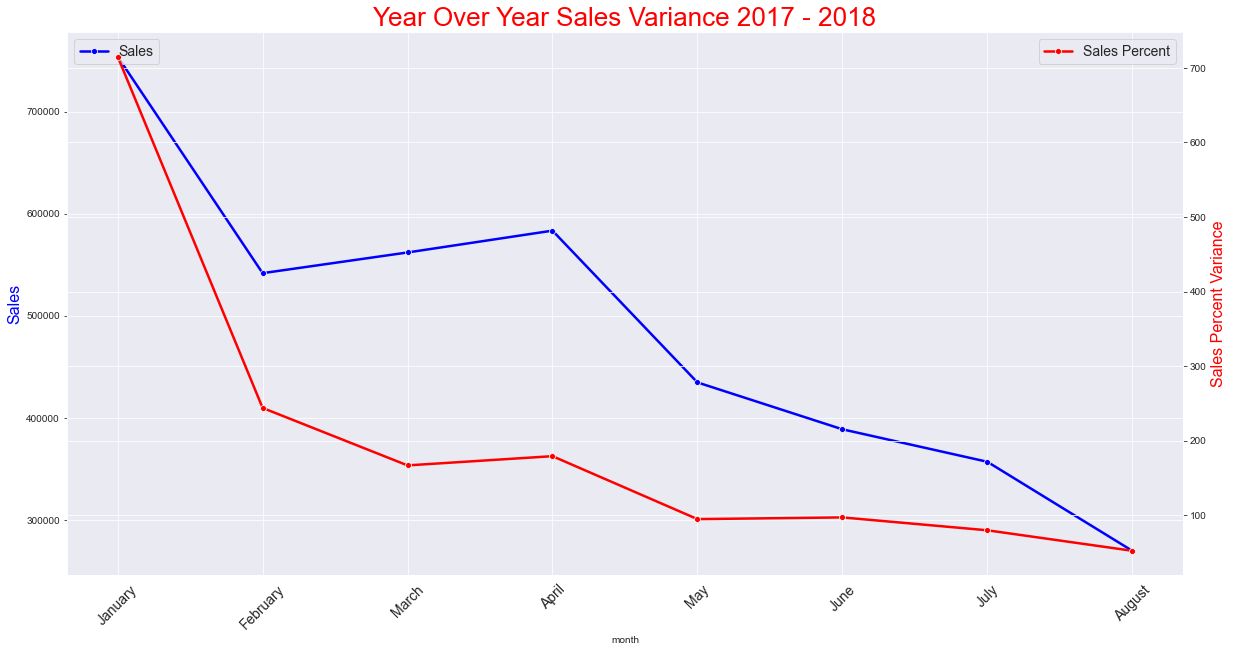

In [19]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('Year Over Year Sales Variance 2017 - 2018', fontsize=26, color="red")

sns.lineplot(data = yoy_2018['yoy_sales'], marker='o', sort = False, ax=ax1, color='blue',linewidth = 2.5)
ax1.set_ylabel('Sales', fontsize=16, color='blue')
ax1.set_xticks(yoy_2018.index)
ax1.set_xticklabels(yoy_2018['month_name'],rotation=45,fontsize=14)
ax1.legend(labels=["Sales"], fontsize=14, loc= 'upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Sales Percent Variance', fontsize=16, color='red')
sns.lineplot(data = yoy_2018['yoy_sales_pct'], marker='o', sort = False, ax=ax2, color='red',linewidth = 2.5)
#ax2.set_xticklabels(yoy_2018['month_name'],rotation=45)
ax2.legend(labels=["Sales Percent"], fontsize=14 , loc='upper right')

plt.show()

In [20]:
state_summary = sales_data.groupby(['state_name','latitude','longatitude','year']).agg({'order_id': 'nunique', 'sales' : 'sum'}).reset_index()
#Rename the columns
state_summary.columns = ['state','latitude','longatitude','year','Order_Count', 'Sales']
# convert the 'Date' column to datetime data type
#state_summary['fdom'] = pd.to_datetime(state_summary['fdom'], format= '%Y-%m-%d')
state_summary.to_csv('state_summary.csv')
#print(state_summary.info())
#print(state_summary.head(24))

In [21]:
print(state_summary.iloc[:,4:6].describe() )

        Order_Count         Sales
count     54.000000  5.400000e+01
mean    1807.500000  2.266746e+05
std     4059.934216  4.681832e+05
min       18.000000  1.323200e+03
25%      192.500000  2.938620e+04
50%      441.000000  6.830549e+04
75%     1473.000000  1.930447e+05
max    23567.000000  2.687108e+06


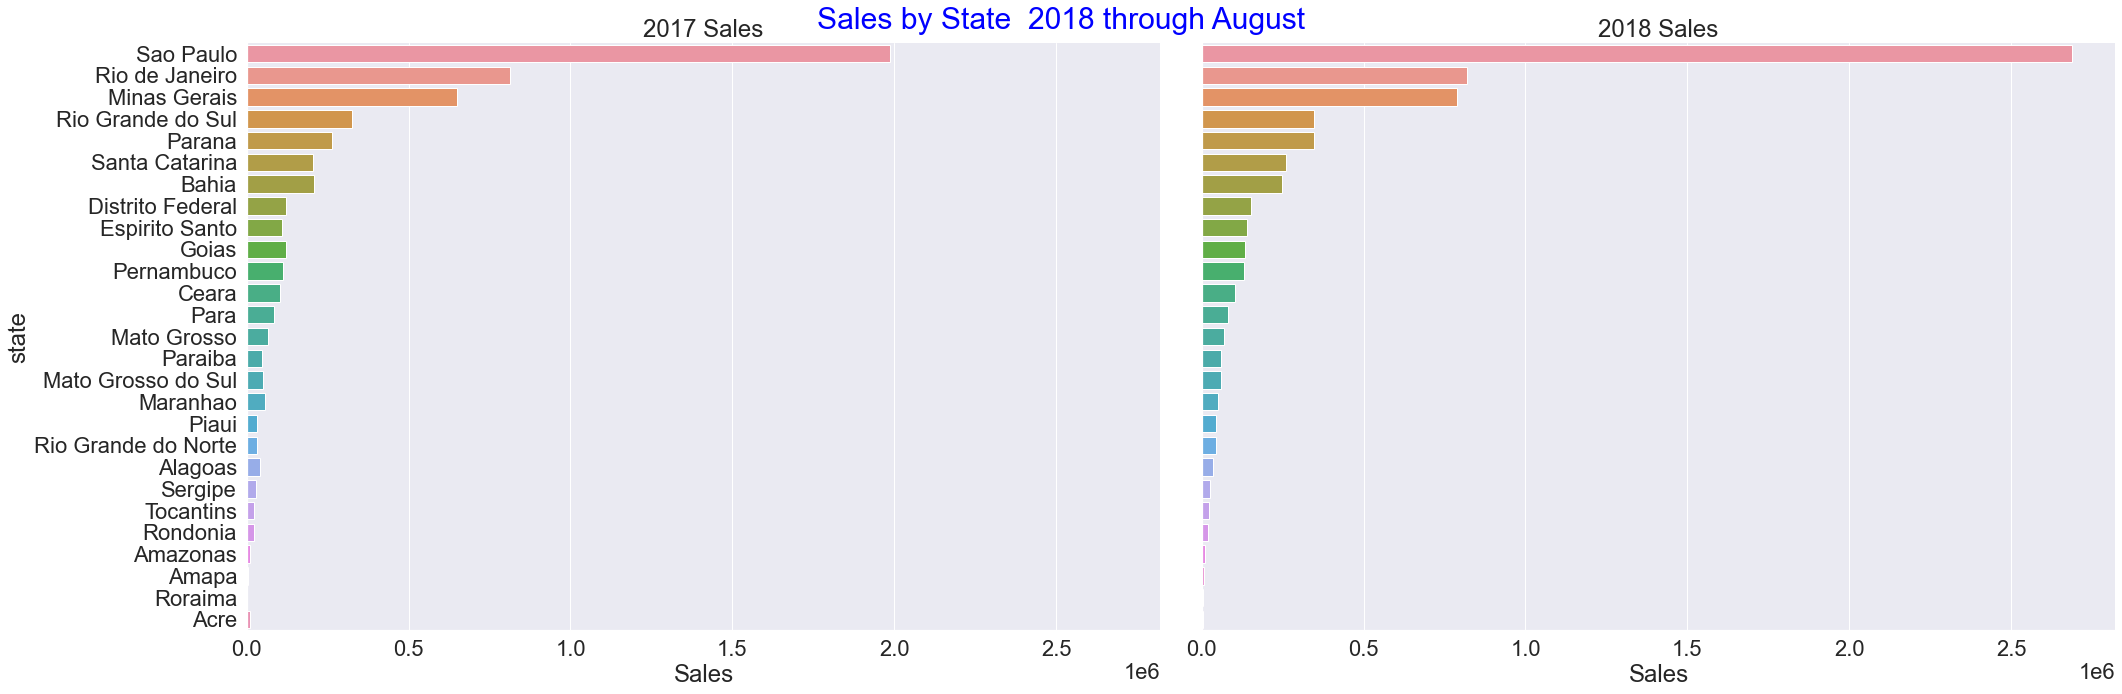

In [22]:
sns.set(rc = {'figure.figsize':(30,20)}, font_scale=2.0)

chart = sns.catplot(data=state_summary, y='state', x='Sales',  col='year', kind='bar',height=10, aspect=1.5 ,
        order=state_summary[state_summary['year'] == 2018].sort_values('Sales',ascending = False).state           
                   )
chart.set_titles(col_template='{col_name} Sales')    
chart.fig.suptitle('Sales by State  2018 through August', fontsize = 30, color = 'blue')
plt.show()

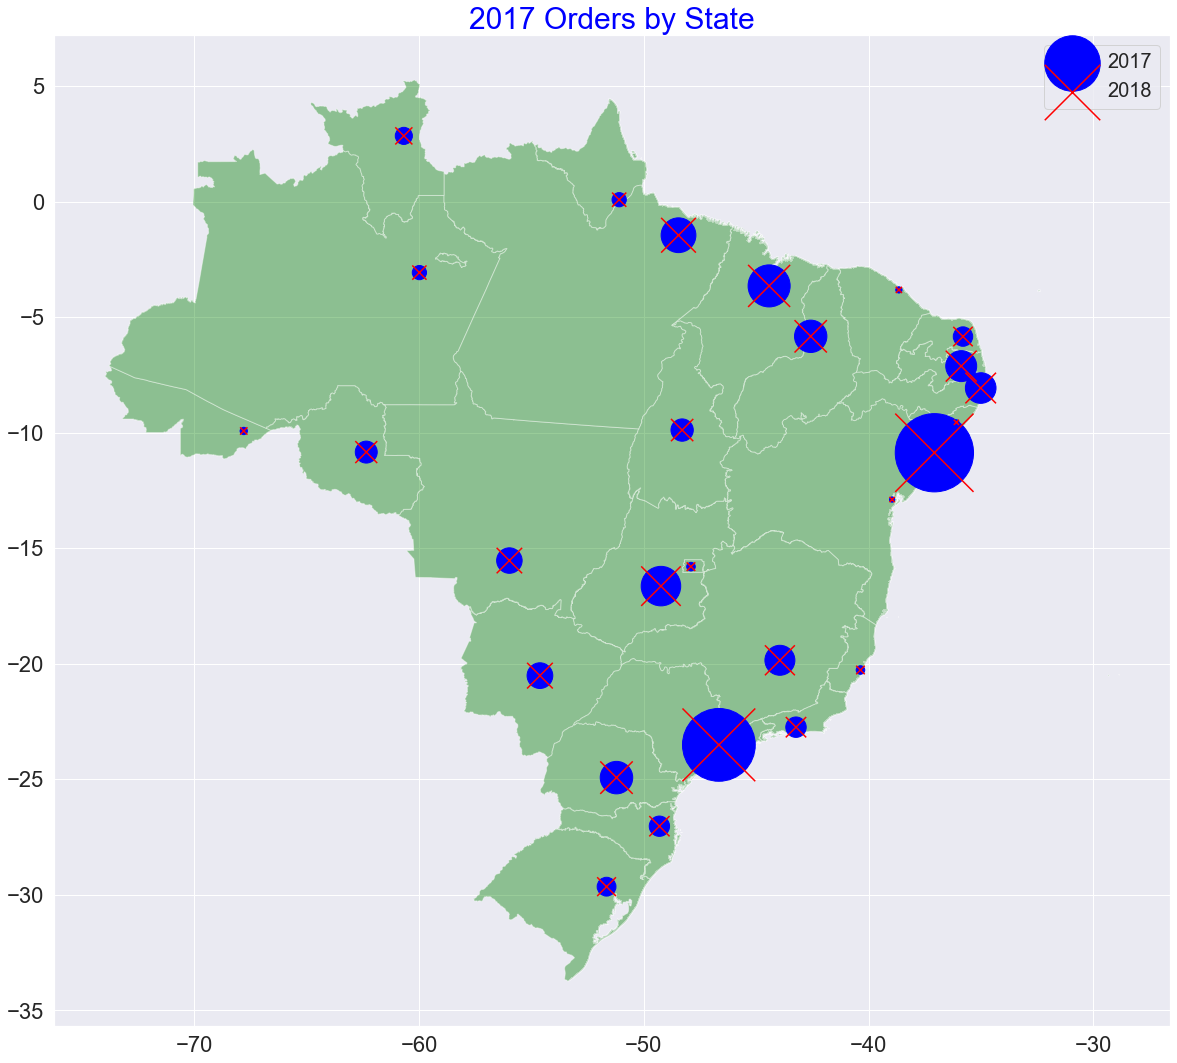

In [23]:
# from https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
#world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
#brazil = world[world.name == "Brazil"]
brazil_map = gpd.read_file('BRA_adm1.shx')
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(state_summary["longatitude"], state_summary["latitude"])]
#geodata=gpd.GeoDataFrame(state_2017[['Sales','longatitude','latitude']],crs=crs, geometry=geometry)
geodata=gpd.GeoDataFrame(state_summary,crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(20,20))
ax.set_title('2017 Orders by State', fontsize = 30, color = 'blue')
brazil_map.plot(ax=ax, alpha=0.4, color ='green')
geodata[geodata.year==2017].plot(ax=ax,markersize= geodata.Order_Count , color='blue',marker='o', label='2017')
geodata[geodata.year==2018].plot(ax=ax,markersize= geodata.Order_Count , color='red',marker='x', label='2018')
plt.legend(prop={'size':20})
geodata.plot

In [24]:
print(sales_data.iloc[:,19].describe() )

count    97605.000000
mean         0.683182
std          4.527573
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        188.000000
Name: days_overdue, dtype: float64


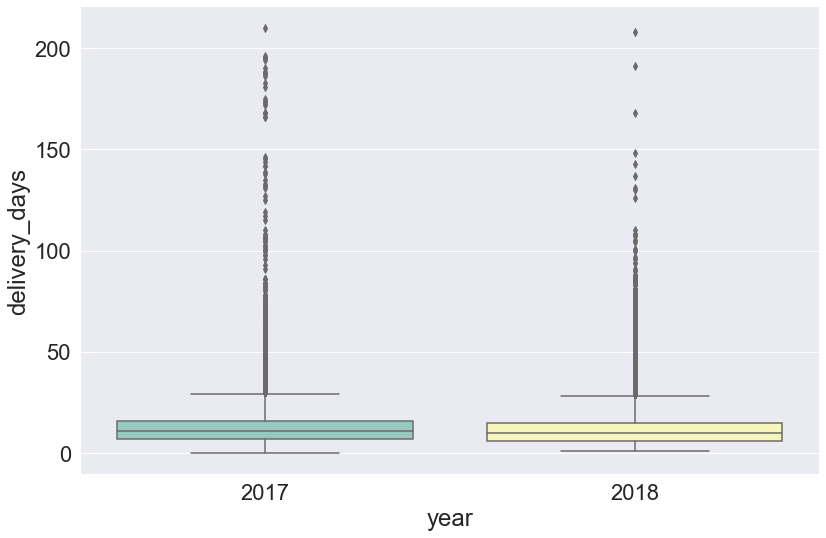

In [25]:
sns.set_style("darkgrid")
sns.catplot(data=sales_data, kind='box',x='year', y='delivery_days', palette='Set3',height=8, aspect=1.5)
plt.show()

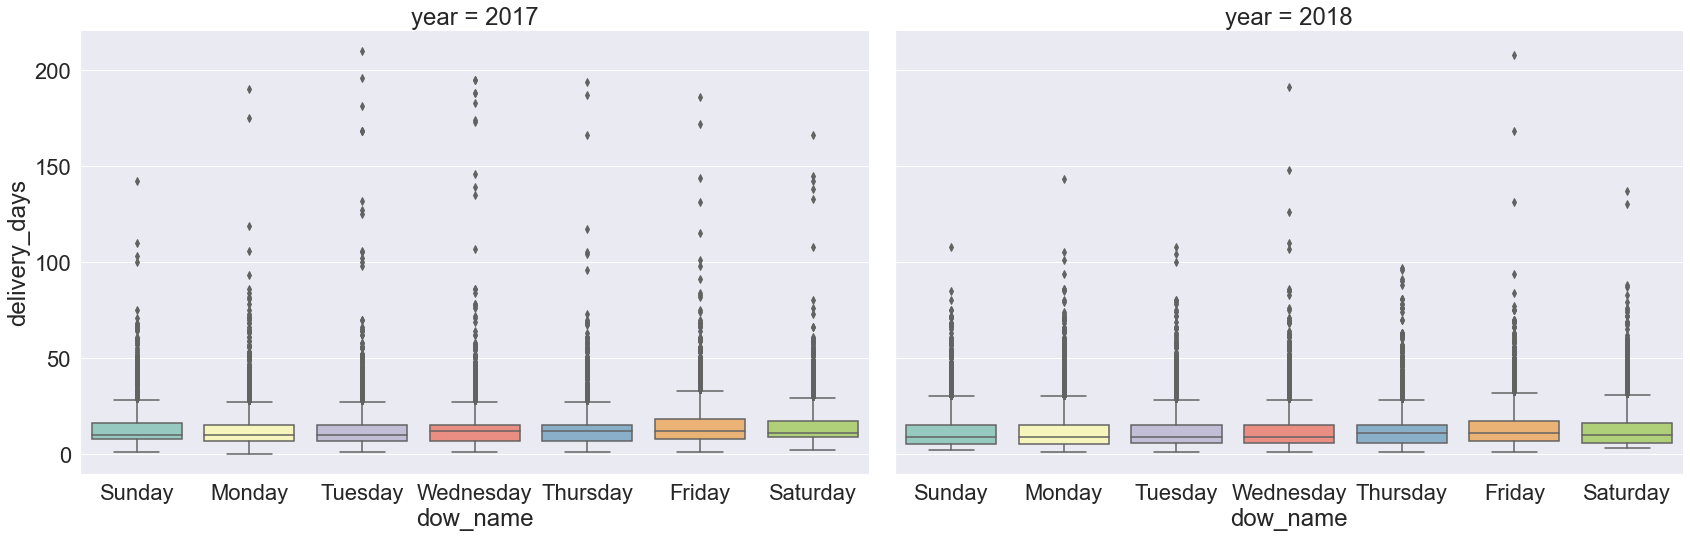

In [26]:
sns.set_style("darkgrid")
sns.catplot(data=sales_data, kind='box', x="dow_name", y='delivery_days',col='year', palette='Set3' ,order = days_list ,height=8, aspect=1.5)

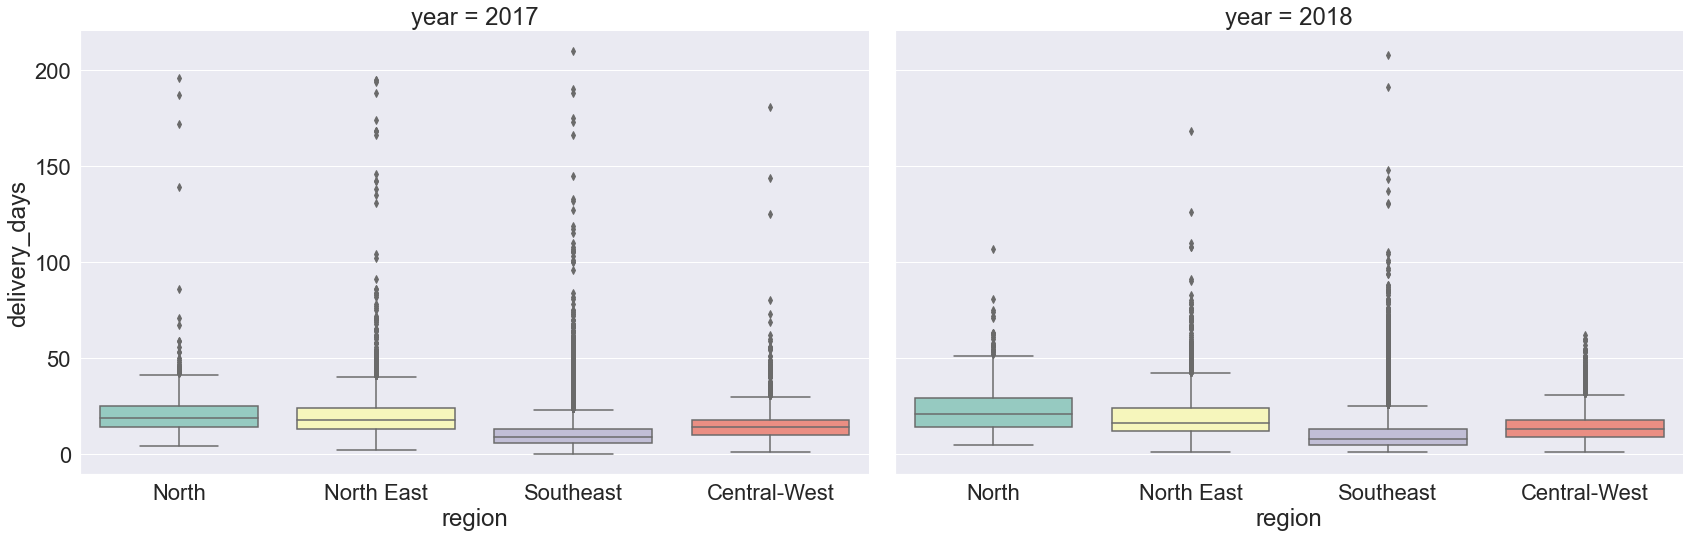

In [27]:
#Boxplots of Delivery days by region
sns.set_style("darkgrid")
sns.catplot(data=sales_data, kind='box', x="region", y='delivery_days',col='year', palette='Set3' ,order = regions_list,height=8, aspect=1.5 )

In [28]:
#Query to get the review scores by date
reviews_query = """select 
                  d.dateyear as "Year",
                  a.order_date,
                  r.review_score,
                  count(distinct r.order_id) as score_count
            from orders a 
            left join reviews r on a.order_id = r.order_id  
            left join date_year d on a.order_date = d.date
            where dateyear in(2017,2018)
            group by 2,3
            having score_count > 0
            order by order_date,review_score """
            
reviews_data = psql.sqldf(reviews_query)
reviews_data['order_date'] = reviews_data['order_date'].apply(pd.to_datetime)
#print(reviews_data.info())
#print(reviews_data.head(10).to_string())
#print(reviews_data.describe())

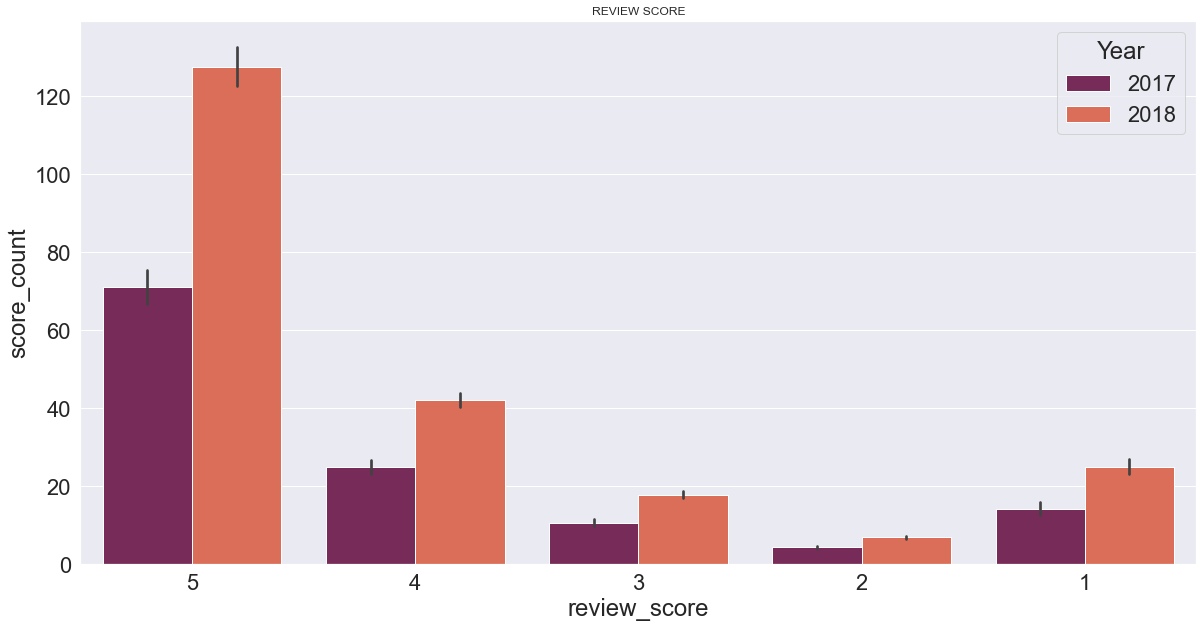

In [29]:
fig, ax1 = plt.subplots(figsize=(20,10))
sns.barplot(x='review_score',y='score_count', data=reviews_data, palette='rocket', order=[5,4,3,2,1], hue=('Year'))
plt.title("REVIEW SCORE", size=12);
plt.show()